In [38]:
cd C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis\

C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis


In [39]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from IPython.display import display
from sys import getsizeof
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# storing data directories for this notebook.
img_out_dir = 'data/images/EDA_NB1_emoji_encoding/'
data_out_dir = 'data/pickled/EDA_NB1_emoji_encoding/'

# used to prin t word cloud in twitter bird shape.
from PIL import Image
wc_image_mask = np.array(Image.open('data/twitter.png'))

%matplotlib inline

## Airline Sentiment Classification

Dataset Description from Kaggle:<br>
Classifies customer sentiment towards major U.S. airlines, based on twitter data. Tweets were scraped from February of 2015 and contributors were asked to classify tweets by positive, negative, and neutral categories, followed by categorizing negative reasons (such as “late flight” or “rude service”).

The Kaggle Dataset contains tweets and categories for 14,640k airline related tweets, classified into one of 3 sentiment categories (positive, negative, neutral). 
<br>Let's see if I can accurately classify the tweet sentiment category based on the text.


### EDA on last 6640 rows of dataset. Had to split rows since calculating the sum of the columns<br>used to kill the kernel.

In [40]:
# reading in 8000 rows but dataset has 14640. I get performance issues.

In [41]:
air_full_df = pd.read_csv("data/csvfiles/kaggle_airline_dataset.csv", encoding='utf-8', nrows=8000)

In [42]:
air_full_df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [43]:
# data size of full kaggle dataset.
air_full_df.shape

(8000, 15)

In [44]:
air_full_df.columns

Index([u'tweet_id', u'airline_sentiment', u'airline_sentiment_confidence',
       u'negativereason', u'negativereason_confidence', u'airline',
       u'airline_sentiment_gold', u'name', u'negativereason_gold',
       u'retweet_count', u'text', u'tweet_coord', u'tweet_created',
       u'tweet_location', u'user_timezone'],
      dtype='object')

In [45]:
air_full_df.airline_sentiment.value_counts()

negative    4560
neutral     1954
positive    1486
Name: airline_sentiment, dtype: int64

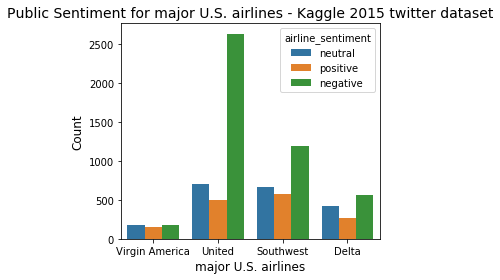

In [46]:
# Airline sentiment.
sns.countplot(x="airline", hue="airline_sentiment", data=air_full_df)
plt.title('Public Sentiment for major U.S. airlines - Kaggle 2015 twitter dataset',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_airline_sentiment_hist.png')

In [47]:
# What are reasons for customer dissatisfaction?
# Explore this to make recommendations at the end from findings.

In [48]:
# plot negative reason value_counts.
neg_reason = air_full_df.negativereason[air_full_df.negativereason.notnull()]
neg_reason.value_counts()

Customer Service Issue         1233
Late Flight                     864
Can't Tell                      680
Lost Luggage                    396
Cancelled Flight                384
Bad Flight                      362
Flight Booking Problems         258
Flight Attendant Complaints     250
longlines                        92
Damaged Luggage                  41
Name: negativereason, dtype: int64

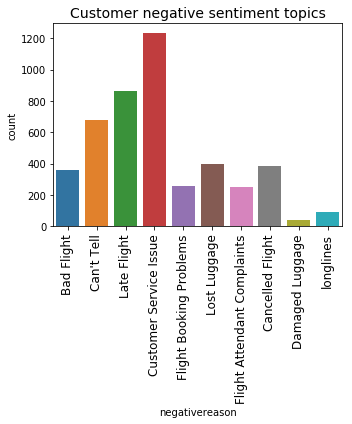

In [49]:
plt.figure(figsize=(5,6))
sns.countplot(x="negativereason", data=air_full_df)
plt.grid(0)
plt.xticks(rotation = 90, fontsize=12)
plt.title("Customer negative sentiment topics", fontsize=14)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_customer_neg_sent_topics_hist.png')

In [50]:
# airlines 
air_full_df.airline.unique()

array([u'Virgin America', u'United', u'Southwest', u'Delta'], dtype=object)

In [51]:
# data types
air_full_df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [52]:
# check for null values.
air_full_df.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  3440
negativereason_confidence       2628
airline                            0
airline_sentiment_gold          7983
name                               0
negativereason_gold             7987
retweet_count                      0
text                               0
tweet_coord                     7388
tweet_created                      0
tweet_location                  2478
user_timezone                   2536
dtype: int64

In [53]:
# get subset with cols = ['airline', 'text', 'airline_sentiment', 'airline_sentiment:confidence']

In [54]:
sub_cols = ['text', 'airline_sentiment', 'airline_sentiment_confidence', 
            'negativereason', 'airline']
air_sub_df = air_full_df.loc[:, sub_cols]

In [55]:
del air_full_df

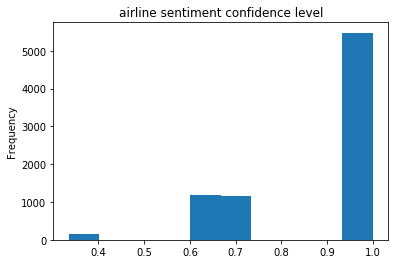

In [56]:
# look at the confidence of values for the 3 categories.
air_sub_df.airline_sentiment_confidence.plot(kind='hist', title='airline sentiment confidence level')
plt.grid(0)

In [57]:
(air_sub_df.airline_sentiment_confidence >= 0.7).sum(), air_sub_df.shape

(5656, (8000, 5))

In [58]:
# let's only keep tweets where the airline_sentiment_confidence is > 0.7

In [59]:
mask = air_sub_df.airline_sentiment_confidence >= 0.7

air_sub_df = air_sub_df.loc[mask,:]

In [60]:
# dataframe with airline sentiment data with 
air_sub_df.shape

(5656, 5)

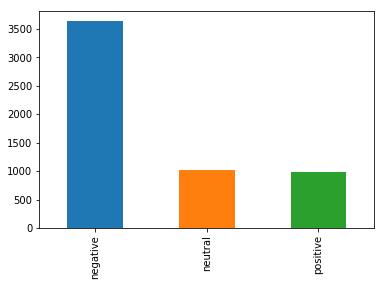

In [61]:
# look at the count of values for the 3 categories.
air_sub_df.airline_sentiment.value_counts().plot(kind='bar')
plt.grid(0)

In [62]:
air_sub_df.head()

text airline_sentiment  \
0                @VirginAmerica What @dhepburn said.           neutral   
3  @VirginAmerica it's really aggressive to blast...          negative   
4  @VirginAmerica and it's a really big bad thing...          negative   
5  @VirginAmerica seriously would pay $30 a fligh...          negative   
9  @VirginAmerica it was amazing, and arrived an ...          positive   

   airline_sentiment_confidence negativereason         airline  
0                           1.0            NaN  Virgin America  
3                           1.0     Bad Flight  Virgin America  
4                           1.0     Can't Tell  Virgin America  
5                           1.0     Can't Tell  Virgin America  
9                           1.0            NaN  Virgin America

In [63]:
air_sub_df[air_sub_df.airline_sentiment == 'positive']['text'][:10]

9     @VirginAmerica it was amazing, and arrived an ...
11    @VirginAmerica I &lt;3 pretty graphics. so muc...
12    @VirginAmerica This is such a great deal! Alre...
14                               @VirginAmerica Thanks!
16    @VirginAmerica So excited for my first cross c...
18                     I ❤️ flying @VirginAmerica. ☺️👍
19    @VirginAmerica you know what would be amazingl...
21    @VirginAmerica I love this graphic. http://t.c...
22    @VirginAmerica I love the hipster innovation. ...
34    @VirginAmerica this is great news!  America co...
Name: text, dtype: object

In [64]:
air_sub_df[air_sub_df.airline_sentiment == 'negative']['text'][:10]

3     @VirginAmerica it's really aggressive to blast...
4     @VirginAmerica and it's a really big bad thing...
5     @VirginAmerica seriously would pay $30 a fligh...
17    @VirginAmerica  I flew from NYC to SFO last we...
24    @VirginAmerica you guys messed up my seating.....
25    @VirginAmerica status match program.  I applie...
26    @VirginAmerica What happened 2 ur vegan food o...
28    @VirginAmerica amazing to me that we can't get...
30    @VirginAmerica hi! I just bked a cool birthday...
32    @VirginAmerica help, left expensive headphones...
Name: text, dtype: object

In [65]:
air_sub_df[air_sub_df.airline_sentiment == 'neutral']['text'][:10]

0                   @VirginAmerica What @dhepburn said.
23    @VirginAmerica will you be making BOS&gt;LAS n...
31    @VirginAmerica Are the hours of operation for ...
42    @VirginAmerica plz help me win my bid upgrade ...
44    @VirginAmerica are flights leaving Dallas for ...
48    @VirginAmerica @ladygaga @carrieunderwood Afte...
52    @VirginAmerica wish you flew out of Atlanta......
53    @VirginAmerica @ladygaga @carrieunderwood Juli...
54    @VirginAmerica Will flights be leaving Dallas ...
58    @VirginAmerica @ladygaga @carrieunderwood - Ca...
Name: text, dtype: object

In [66]:
# target.
y = air_sub_df['airline_sentiment']

In [67]:
# unique values of y.
y.unique()

array([u'neutral', u'negative', u'positive'], dtype=object)

In [68]:
#*********** Let's try to look at the top words in each of the categories, using CountVectorizer() *************

In [69]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [70]:
from nltk.stem.porter import PorterStemmer
import emoji
import string

In [71]:
# exclude name of airlines from the tweets. 
exclude = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways',
           'americanair', 'jetblue', 'southwest', 'flight', 'flights',
           'URL', 'AT_USER', 'amp', 'amp;']

In [72]:
# define stop words. Use the defined 'english' stop words. I will add the airline names to that.
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(exclude)
exclude_punctuation = set(string.punctuation) 

In [75]:
# read in pickled emoji dictionary I created from emojis in the dataset. I want to use
# each emoji as an individual feature.
with open('data/pickled/Emoticon_NB4/full_emoji_dict.obj','rb') as file:
    emoji_dict = pickle.load(file)
            
# I also made a reverse lookup dict.
file = open('data/pickled/Emoticon_NB4/reverse_lookup_full_emoji_dict.obj','rb')
reverse_lookup_emoji_dict = pickle.load(file)            

ValueError: unsupported pickle protocol: 3

In [ ]:
print(emoji_dict)

In [ ]:
def encode_emojis(text):
    input_txt = text
    for word in text:
        if word in emoji.UNICODE_EMOJI:
            input_txt = input_txt.replace(word, emoji_dict[word])
    return(input_txt)

In [ ]:
def extract_emojis(text):
    return(' '.join(word for word in text if word in emoji.UNICODE_EMOJI))

In [ ]:
def tokenize(text):
    return(text.split())

In [ ]:
def cleaner(text):
    
    # convert text to lowercase.
    text = text.lower()
    # remove www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # remove @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove some punctuation symbols.
    text= ''.join(ch for ch in text if ch not in exclude_punctuation)
    # clean
    text = re.sub('&#39;','',text).lower()
    # trim
    text = text.strip('\'"')
    # trim any leading or trailing white spaces.
    text = text.strip()

    return(text)

In [ ]:
# remove stopwords.
def remove_stopwords(text):
    '''
    remove english stop words
    '''
    token_text = tokenize(text)
    text = ' '.join(i for i in token_text if (i not in stop_words))
    return(text)

In [ ]:
def stemming(text):
    '''
    replaces words with its stem word (ie thanks-> thanks, fly->fli,...)
    '''
    ps = PorterStemmer()
    text = tokenize(text)
    text = ' '.join(ps.stem(word) for word in text)
    return(text)

In [ ]:
def declump_emojis_in_text(text):
    em_txt = text        
    for i in text:
        if (i in emoji.UNICODE_EMOJI):
            em_txt = em_txt.replace(i,' '+i)
        
    return(em_txt)

## Clean Text
```(eliminate web tags, punctuation, symbols...)```

In [ ]:
air_sub_df.columns

In [ ]:
# create a new category 'clean_text' with clean text.
air_sub_df['clean_text'] = air_sub_df['text'].apply(cleaner)

In [ ]:
# Let's see what the clean data looks like.

In [ ]:
air_sub_df[['clean_text', 'text']][y=='positive'][:10]

In [ ]:
air_sub_df.loc[18, 'text'], air_sub_df.loc[19, 'text']

In [ ]:
air_sub_df.loc[18, 'clean_text'], air_sub_df.loc[19, 'clean_text']

In [ ]:
air_sub_df[['clean_text', 'text']][y=='negative'][:10]

In [ ]:
air_sub_df.loc[3, 'text'] 

In [ ]:
air_sub_df.loc[3, 'clean_text']

In [ ]:
air_sub_df[['clean_text', 'text']][y=='neutral'][:10]

In [ ]:
air_sub_df.loc[44, 'text']

In [ ]:
air_sub_df.loc[44, 'clean_text']

In [ ]:
# users clump emojis together with words. I want to vectorize them as 
# separate individual features - where each unique emoji in training corpus 
# is a feature. 

# NOTE: later maybe I should change this so many more emojis are incorporated as
# features - not just the ones in the training corpus. 

In [ ]:
# example of clumped emoji.
air_sub_df.loc[18, 'clean_text']

In [ ]:
# right now ☺️👍 will be a feature. I want features independent 
# as ☺️ and 👍. Let's declump them.

air_sub_df['clean_text'] = air_sub_df['clean_text'].apply(declump_emojis_in_text)

In [ ]:
air_sub_df.loc[18, 'clean_text']

In [ ]:
# notice now the emoji is a separate feature.

In [ ]:
# Now let's encode the emojis so we can use it in the vectorizer as a feature.
air_sub_df['clean_text'] = air_sub_df['clean_text'].apply(encode_emojis)

In [ ]:
air_sub_df.loc[18, 'clean_text']

In [ ]:
# The emojis from above are now encoded.

In [ ]:
# now I want to create a separate col that stores a list of emojis
# in the text, if any are present. This may be useful for exploring
# sentiment and emoji relationships further.

In [ ]:
# create a new category 'emojis' with emojis.
air_sub_df['emojis'] = air_sub_df['text'].apply(extract_emojis)

In [ ]:
air_sub_df[air_sub_df['emojis']!=''][:5]

## Reduce dimensionality - using english stop words
```(eliminating english stop words that typically don't impart much meaning like prepositions, pronouns... I will also remove twitter handle and urls encoded above, in the cleaner method, as AT_USER and URL.```

In [ ]:
# create a new category 'stopw_clean_text' to store reduced dimensionality text,
# by eliminating english stop words.
air_sub_df['stopw_clean_text'] = air_sub_df['clean_text'].apply(remove_stopwords)

In [ ]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='positive'][:10]

In [ ]:
air_sub_df.loc[12, 'clean_text']

In [ ]:
air_sub_df.loc[12, 'stopw_clean_text']

In [ ]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='negative'][:10]

In [ ]:
air_sub_df.loc[25, 'clean_text']

In [ ]:
air_sub_df.loc[25, 'stopw_clean_text']

In [ ]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='neutral'][:10]

In [ ]:
air_sub_df.loc[42, 'clean_text']

In [ ]:
air_sub_df.loc[42, 'stopw_clean_text']

## Further reduce dimensionality - using stemming 
```(Stemming attempts to find the root of the word by chopping off the end, like thanks becoms thank...)```

In [ ]:
# create a new category 'stem_stopw_clean_text' to store reduced dimensionality text,
# by finding root of words.
air_sub_df['stem_stopw_clean_text'] = air_sub_df['stopw_clean_text'].apply(stemming)

In [ ]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='positive'][:10]

In [ ]:
air_sub_df.loc[19, 'stopw_clean_text']

In [ ]:
air_sub_df.loc[19, 'stem_stopw_clean_text']

In [ ]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='negative'][:10]

In [ ]:
air_sub_df.loc[25, 'stopw_clean_text']

In [ ]:
air_sub_df.loc[25, 'stem_stopw_clean_text']

In [ ]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='neutral'][:10]

In [ ]:
air_sub_df.loc[42, 'stopw_clean_text']

In [ ]:
air_sub_df.loc[42, 'stem_stopw_clean_text']

In [ ]:
# Let's make a word cloud to visualize the clean text data.

In [ ]:
def make_wordcloud(data, title, filename, mask):
    plt.figure(figsize=(7,7))
    im = WordCloud(max_words=300, mask=mask).generate(' '.join(i for i in data))
    plt.grid(0)
    plt.title(title, fontsize=14)
    im.to_file(img_out_dir+filename)
    plt.imshow(im)

## Positive class

In [ ]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='positive']
title = "Positive sentiment:  cleaned text"
filename = 'WordCld_pos_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stopwords"
filename = 'WordCld_pos_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stemming"
filename = 'WordCld_pos_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Negative class

In [ ]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='negative']
title = "Negative sentiment:  cleaned text"
filename = 'WordCld_neg_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stopwords"
filename = 'WordCld_neg_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stemming"
filename = 'WordCld_neg_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

In [ ]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='neutral']
title = "Neutral sentiment:  cleaned text"
filename = 'WordCld_neut_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stopwords"
filename = 'WordCld_neut_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stemming"
filename = 'WordCld_neut_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Feature extraction using CountVectorizer() 
```compare results of using 'clean text', 'added stopwords', and 'added stemming'.```<br>
```NOTE: I am passing a custom token pattern to the vectorizers because I want to```<br>
```use the emojis as features.```

## Look at uni-grams 

In [ ]:
grams = "Unigrams"

In [ ]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(1,1))                     
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(1,1))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(1,1))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y


In [ ]:
print(words_df.shape)
words_df.head(4)

In [ ]:
print(words_stop_df.shape)
words_stop_df.head(4)

In [ ]:
print(words_stem_df.shape)
words_stem_df.head(4)

In [ ]:
# We see that the dimensions of the features reduced from 8647 with clean text, 
# to 8382 with stopwords and 6801 with stemming.

### Positive Sentiment

In [ ]:
def disp_positive_grams(words_df, words_stop_df, words_stem_df, grams):

    words_sorted_ordimp = words_df[words_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Positive Sentiment: cleaned text', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_pos_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Positive Sentiment: added stopwords', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_pos_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "positive"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Positive Sentiment: added stemming', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_pos_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)


In [ ]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

In [ ]:
def disp_negative_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Negative Sentiment: cleaned text', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neg_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Negative Sentiment: added stopwords', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neg_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "negative"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Negative Sentiment: added stemming', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neg_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

In [ ]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

In [ ]:
def disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Neutral Sentiment: cleaned text', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neut_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Neutral Sentiment: added stopwords', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neut_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "neutral"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Neutral Sentiment: added stemming', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neut_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

In [ ]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at bi-grams

In [ ]:
grams = "Bigrams"

In [ ]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(2,2))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(2,2))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(2,2))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [ ]:
print(words_df.shape)
words_df.head(4)

In [ ]:
print(words_stop_df.shape)
words_stop_df.head(1)

In [ ]:
print(words_stem_df.shape)
words_stem_df.head(4)

In [ ]:
# Feature dimension reduced from 46868 with cleaned text, to 33327 with stopwords and
# 31824 with stemming.

## Positive

In [ ]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

In [ ]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

In [ ]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at tri-grams

In [ ]:
grams = "Trigrams"

In [ ]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(3,3))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(3,3))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(3,3))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [ ]:
print(words_df.shape)
words_df.head(1)

In [ ]:
print(words_stop_df.shape)
words_stop_df.head(1)

In [ ]:
print(words_stem_df.shape)
words_stem_df.head(1)

In [ ]:
# dimensionality reduced from 68410, to 33268, 33068

## Positive

In [ ]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

In [ ]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

In [ ]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

In [ ]:
# Pickle dataframe with added columns with processed and cleaned text.
import pickle

In [ ]:
data_out_dir

In [ ]:
filename = data_out_dir+'airline_cl_process_dataset_df1'
filehandler = open(filename,"wb")
pickle.dump(air_sub_df,filehandler)

In [ ]:
file = open(filename,'rb')
object_content = pickle.load(file)

In [ ]:
#**************** I did not encode emojis. What did count vectorizer do with them? Let's explore.

In [ ]:
# emoji in text.
text1 = air_sub_df.loc[42, 'clean_text']
text2 = air_sub_df.loc[42, 'stopw_clean_text']

In [ ]:
text1, text2

In [ ]:
def disp_transformed_text_tokens(vectorizer, text):
    text_vect = vectorizer.transform([text])
    text_df = pd.DataFrame(text_vect.toarray(), columns=vectorizer.get_feature_names())
    words = text_df.sum().sort_values(ascending=False)
    words.head(10).plot(kind='barh',figsize=(3,4), fontsize=12)
    print(text)
    plt.show()

In [ ]:
disp_transformed_text_tokens(cv, text1)
disp_transformed_text_tokens(cv, text2)

In [ ]:
reverse_lookup_emoji_dict['EMOJI_8'], reverse_lookup_emoji_dict['EMOJI_3'], reverse_lookup_emoji_dict['EMOJI_9'], reverse_lookup_emoji_dict['EMOJI_8'],reverse_lookup_emoji_dict['EMOJI_7'] 

In [ ]:
# Emojis are encoded. Now use this data for modelling and see what effects
# emojis have on predictions. Explore this further in another notebook.